In [26]:
import pandas as pd
from datetime import datetime
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [27]:
#H(h)_m: Irradiation on horizontal plane (kWh/m2/mo)
#Kd: Ratio of diffuse to global irradiation (-)
#T2m: 24 hour average of temperature (degree Celsius)

dfera = pd.read_csv('C:/Users/Carlos Eduardo/Downloads/Área de Trabalho/GitHub/WeatherPrediction/data/solar_irradiation_sp/PVGIS-ERA5_E5_2005_2020.csv', sep=';')
dfsarah = pd.read_csv('C:/Users/Carlos Eduardo/Downloads/Área de Trabalho/GitHub/WeatherPrediction/data/solar_irradiation_sp/PVGIS-SARAH2_2005_2020.csv', sep=';')

dfopenw = pd.read_csv('C:/Users/Carlos Eduardo/Downloads/Área de Trabalho/GitHub/WeatherPrediction/data/openweather_data.csv')

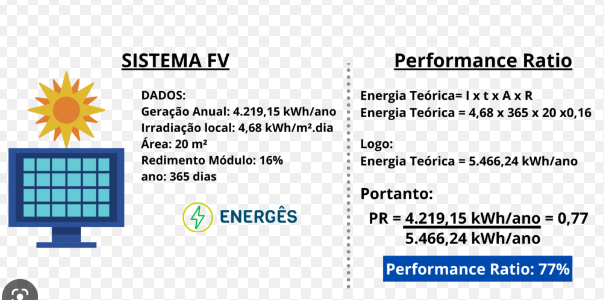

- juntar os dados de irradiação no conjunto de dados da openweather API
- treinar predições de irradiação para estimar o quanto um usuário (comprador de placa(s) solar(es)) teria de perfomance em sua(s) placa(s) solar(es) 

- **NOSSA API:** 

O cliente usaria nossa API inserindo os dados da(s) placa(s) solare(es), como, *geração anual*, *área*, *rendimento módulo*. A partir disso, usaremos os dados de irradiação previstos + tempo (mensal) para calcular a perfomance da placa solar

In [28]:
dfera.head()

,year,Unnamed: 1,month,Unnamed: 3,H(h)_m,Unnamed: 5,Kd,Unnamed: 7,T2m
0,2005,NaN,Jan,NaN,141.11,NaN,0.44,NaN,21.9
1,2005,NaN,Feb,NaN,164.43,NaN,0.32,NaN,20.8
2,2005,NaN,Mar,NaN,145.34,NaN,0.36,NaN,21.3
3,2005,NaN,Apr,NaN,128.28,NaN,0.32,NaN,20.7
4,2005,NaN,May,NaN,123.55,NaN,0.26,NaN,18.6


In [29]:
dfsarah.head()

,year,Unnamed: 1,month,Unnamed: 3,H(h)_m,Unnamed: 5,Kd,Unnamed: 7,T2m
0,2005,NaN,Jan,NaN,135.96,NaN,0.55,NaN,21.9
1,2005,NaN,Feb,NaN,162.91,NaN,0.45,NaN,20.8
2,2005,NaN,Mar,NaN,138.82,NaN,0.52,NaN,21.3
3,2005,NaN,Apr,NaN,133.84,NaN,0.40,NaN,20.7
4,2005,NaN,May,NaN,117.79,NaN,0.38,NaN,18.6


In [30]:
dfera.dropna(thresh=len(dfera)*0.5, axis=1, inplace=True)
dfsarah.dropna(thresh=len(dfsarah)*0.5, axis=1, inplace=True)

In [31]:
dfsarah.head(), dfsarah.tail()

(   year month  H(h)_m    Kd   T2m
 0  2005   Jan  135.96  0.55  21.9
 1  2005   Feb  162.91  0.45  20.8
 2  2005   Mar  138.82  0.52  21.3
 3  2005   Apr  133.84  0.40  20.7
 4  2005   May  117.79  0.38  18.6,
      year month  H(h)_m    Kd   T2m
 187  2020   Aug  133.68  0.31  17.1
 188  2020   Sep  151.77  0.39  21.5
 189  2020   Oct  165.86  0.41  20.6
 190  2020   Nov  185.15  0.43  20.0
 191  2020   Dec  166.73  0.54  21.0)

In [32]:
print('NULL VALUES /n /n')
print('dfera')
print(f'{dfera.isnull().sum()} /n')
print('dfsarah')
print(f'{dfsarah.isnull().sum()} /n')
print('dfopenw')
for column in dfopenw.columns:
    display(f'{column} {dfopenw[column].isnull().sum()}')

NULL VALUES /n /n
dfera
year      0
month     0
H(h)_m    0
Kd        0
T2m       0
dtype: int64 /n
dfsarah
year      0
month     0
H(h)_m    0
Kd        0
T2m       0
dtype: int64 /n
dfopenw


'dt 0'

'sunrise 0'

'sunset 0'

'temp ºC 0'

'feels_like ºC 0'

'pressure 0'

'humidity % 0'

'atmospheric temperature 0'

'clouds % 0'

'visibility 877'

'wind_speed m/s 0'

'wind_deg 0'

'weather 0'

'rain_precipitation 6767'

'wind_gust 7500'

'uvi 7755'

'weather_id 0'

Juntar o df_irrad_openw com os dados mensais (2005 - 2020) de irradiação solar. Para isso, precisamos encontrar uma maneira de transformar o df_irrad_openw, que é um dataset com dados diários, em dados mensais

In [33]:
columns = ['dt', 'temp ºC', 'feels_like ºC', 'pressure', 'humidity %', 
           'clouds %', 'visibility', 'wind_speed m/s', 'rain_precipitation', 'weather_id']

df_irrad_openw = dfopenw[columns]

In [34]:
df_irrad_openw

,dt,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,rain_precipitation,weather_id
0,2001-12-31,21.84,22.09,1010,77,40,10000.0,0.00,NaN,802
1,2002-01-01,20.75,20.94,1010,79,40,10000.0,2.10,NaN,802
2,2002-01-02,21.54,21.34,1011,61,20,10000.0,0.00,NaN,801
3,2002-01-03,21.30,21.44,1013,75,75,9000.0,2.60,NaN,721
4,2002-01-04,20.59,20.69,1015,76,20,7000.0,5.10,NaN,721
...,...,...,...,...,...,...,...,...,...,...
7755,2023-03-26,23.27,23.92,1019,87,40,10000.0,8.49,{'1h': 3.65},501
7756,2023-03-27,19.46,19.73,1021,87,75,10000.0,4.92,NaN,803
7757,2023-03-28,20.75,21.20,1020,89,40,10000.0,4.12,NaN,802
7758,2023-03-29,22.08,22.35,1020,77,0,10000.0,1.54,NaN,800


In [35]:
#changing the rain_precipitation values using regex

new_values = []

for value in df_irrad_openw['rain_precipitation']:
    if pd.isnull(value) == True:
        value = np.nan
        new_values.append(value)
    else:
        value = re.sub("{'1h':", "", value)
        value = re.sub(" ", "", value)
        value = re.sub("}", "", value)
        new_values.append(value)
            
new_values

#adding the new values using regex
df_irrad_openw = df_irrad_openw.drop(['rain_precipitation'], axis=1)
df_irrad_openw['rain_precip'] = new_values

In [36]:
#dt --> str to datetime
df_irrad_openw['dt'] = pd.to_datetime(df_irrad_openw['dt'], format='%Y-%m-%d')
df_irrad_openw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760 entries, 0 to 7759
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   dt              7760 non-null   datetime64[ns]
 1   temp ºC         7760 non-null   float64       
 2   feels_like ºC   7760 non-null   float64       
 3   pressure        7760 non-null   int64         
 4   humidity %      7760 non-null   int64         
 5   clouds %        7760 non-null   int64         
 6   visibility      6883 non-null   float64       
 7   wind_speed m/s  7760 non-null   float64       
 8   weather_id      7760 non-null   int64         
 9   rain_precip     993 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 606.4+ KB


In [37]:
#creating the columns year, month, day

df_irrad_openw['year'] = [date.year for date in df_irrad_openw['dt']]
df_irrad_openw['month'] = [date.month for date in df_irrad_openw['dt']]
df_irrad_openw['day'] = [date.day for date in df_irrad_openw['dt']]

#transforming that columns in datetime type
# df_irrad_openw['year'] = pd.to_datetime(df_irrad_openw['year'], format='%Y')
# df_irrad_openw['month'] = pd.to_datetime(df_irrad_openw['month'], format='%m')
# df_irrad_openw['day'] = pd.to_datetime(df_irrad_openw['day'], format='%d')

In [38]:
#df info and checking null values

df_irrad_openw.info()
print('/nNULL VALUES')
for feature in df_irrad_openw.columns:
        if any(df_irrad_openw[feature].isnull()) == True:
                print(f"{feature} --> {round((df_irrad_openw[feature].isnull().sum() / df_irrad_openw.shape[0]), 3)*100}% null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760 entries, 0 to 7759
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   dt              7760 non-null   datetime64[ns]
 1   temp ºC         7760 non-null   float64       
 2   feels_like ºC   7760 non-null   float64       
 3   pressure        7760 non-null   int64         
 4   humidity %      7760 non-null   int64         
 5   clouds %        7760 non-null   int64         
 6   visibility      6883 non-null   float64       
 7   wind_speed m/s  7760 non-null   float64       
 8   weather_id      7760 non-null   int64         
 9   rain_precip     993 non-null    object        
 10  year            7760 non-null   int64         
 11  month           7760 non-null   int64         
 12  day             7760 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(7), object(1)
memory usage: 788.2+ KB
/nNULL VALUES
visibility --> 1

In [39]:
#drop rain_precip -> 87% null values
df_irrad_openw.drop(['rain_precip'], axis=1, inplace=True)

**transformar o df_irrad_openw em dados mensais que nem o dfera/dfsarah para termos dados climáticos + irradiação solar em 1 df?**

In [40]:
# df_irrad_openw.groupby(['year', 'month']).mean()

In [41]:
#creating the monthly mean data since 2005 - 2020 (time that we have for irradiation data)

df_to_join_irrad = df_irrad_openw.groupby(['year', 'month']).mean()
df_to_join_irrad = df_to_join_irrad.reset_index()
df_to_join_irrad

,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,weather_id,day
0,2001,12,21.840000,22.090000,1010.000000,77.000000,40.000000,10000.000000,0.000000,802.000000,31.0
1,2002,1,21.121935,21.348065,1016.225806,78.838710,61.612903,8580.645161,2.783226,664.000000,16.0
2,2002,2,20.439286,20.619286,1016.821429,79.678571,68.714286,8821.428571,3.253571,699.857143,14.5
3,2002,3,22.334839,22.641613,1017.967742,77.258065,52.967742,7826.666667,2.810968,732.870968,16.0
4,2002,4,20.738667,20.930667,1019.466667,78.933333,40.666667,8166.666667,2.776667,720.333333,15.5
...,...,...,...,...,...,...,...,...,...,...,...
251,2022,11,17.314667,17.283000,1004.066667,83.566667,38.500000,9533.333333,4.468333,744.633333,15.5
252,2022,12,19.867742,20.172258,1003.903226,86.645161,53.354839,9516.129032,3.920645,669.000000,16.0
253,2023,1,20.964194,21.406452,1013.806452,87.677419,44.677419,8645.161290,3.611290,680.290323,16.0
254,2023,2,21.243571,21.784286,1010.750000,90.428571,41.785714,8617.857143,3.705357,597.357143,14.5


In [42]:
df_to_join_irrad = df_to_join_irrad.drop(df_to_join_irrad.query('year < 2005').index)
df_to_join_irrad = df_to_join_irrad.drop(df_to_join_irrad.query('year > 2020').index)
df_to_join_irrad

,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,weather_id,day
37,2005,1,21.041290,21.445806,1015.193548,86.161290,71.290323,7741.935484,3.296774,600.774194,16.0
38,2005,2,20.410000,20.680000,1016.750000,83.250000,46.428571,8714.285714,3.589286,726.750000,14.5
39,2005,3,20.905806,21.217097,1018.161290,82.935484,54.354839,8129.032258,3.403226,661.935484,16.0
40,2005,4,20.427667,20.655000,1020.000000,81.533333,56.166667,8017.241379,3.131667,696.533333,15.5
41,2005,5,18.132258,18.061290,1020.709677,78.903226,45.000000,7933.333333,2.178065,716.612903,16.0
...,...,...,...,...,...,...,...,...,...,...,...
224,2020,8,16.638065,16.261935,1020.225806,75.419355,33.870968,9193.548387,3.257742,711.709677,16.0
225,2020,9,20.469333,20.342333,1019.166667,68.500000,46.000000,8300.000000,3.676333,709.633333,15.5
226,2020,10,19.894839,19.894839,1014.096774,76.483871,54.838710,8919.354839,3.698710,697.161290,16.0
227,2020,11,19.398000,19.384000,1017.633333,75.433333,51.000000,9133.333333,4.270667,740.100000,15.5


In [43]:
dfsarah.shape

(192, 5)

In [44]:
#joining
df_to_join_irrad['irrad kwh/m2'] = dfsarah['H(h)_m'].values
df_to_join_irrad

,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,weather_id,day,irrad kwh/m2
37,2005,1,21.041290,21.445806,1015.193548,86.161290,71.290323,7741.935484,3.296774,600.774194,16.0,135.96
38,2005,2,20.410000,20.680000,1016.750000,83.250000,46.428571,8714.285714,3.589286,726.750000,14.5,162.91
39,2005,3,20.905806,21.217097,1018.161290,82.935484,54.354839,8129.032258,3.403226,661.935484,16.0,138.82
40,2005,4,20.427667,20.655000,1020.000000,81.533333,56.166667,8017.241379,3.131667,696.533333,15.5,133.84
41,2005,5,18.132258,18.061290,1020.709677,78.903226,45.000000,7933.333333,2.178065,716.612903,16.0,117.79
...,...,...,...,...,...,...,...,...,...,...,...,...
224,2020,8,16.638065,16.261935,1020.225806,75.419355,33.870968,9193.548387,3.257742,711.709677,16.0,133.68
225,2020,9,20.469333,20.342333,1019.166667,68.500000,46.000000,8300.000000,3.676333,709.633333,15.5,151.77
226,2020,10,19.894839,19.894839,1014.096774,76.483871,54.838710,8919.354839,3.698710,697.161290,16.0,165.86
227,2020,11,19.398000,19.384000,1017.633333,75.433333,51.000000,9133.333333,4.270667,740.100000,15.5,185.15


In [46]:
df_to_join_irrad.to_csv("openw_irradiation_2005_2020.csv", index=False)